# A comparison of 10K cohort thrombolysis rates across hospitals

## Aims:

* Train XGBoost model on all data except for a 10K set of patients
* Predict use of thrombolysis in 10K cohort at each of 132 hospitals (by changing hospital one-hot coding).

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from xgboost import XGBClassifier

## Create output folders if needed

In [2]:
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Load data

In [3]:
data_loc = '../data/10k_training_test/'

train = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

## Combined XGBoost Model

In [4]:
# Get X and y
X_train = train.drop('S2Thrombolysis', axis=1)
X_test = test.drop('S2Thrombolysis', axis=1)
y_train = train['S2Thrombolysis']
y_test = test['S2Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['StrokeTeam'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('StrokeTeam', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['StrokeTeam'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('StrokeTeam', axis=1, inplace=True)

learning_rates = [0.1, 0.25, 0.5, 0.75, 1.0]
thrombolysis_rates_by_lr = dict()

for lr in learning_rates:

    # Define model
    model = XGBClassifier(verbosity = 0, seed=42, learning_rate=lr)

    # Fit model
    model.fit(X_train, y_train)

    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test)[:,1]
    y_pred = y_probs > 0.5

    # Show accuracy
    accuracy = np.mean(y_pred == y_test)
    print (f'Learning rate: {lr}. Accuracy: {accuracy:0.3f}')
    
    # Pass 10k cohort through all hospital models and get thrombolysis rate
    hospitals = list(set(train['StrokeTeam']))
    hospitals.sort()
    thrombolysis_rate = []
    single_predictions = []

    for hospital in hospitals:

        # Get test data without thrombolysis hospital or stroke team
        X_test_no_hosp = test.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)

        # Copy hospital dataframe and change hospital ID (after setting all to zero)
        X_test_adjusted_hospital = X_test_hosp.copy()
        X_test_adjusted_hospital.loc[:,:] = 0
        team = "team_" + hospital
        X_test_adjusted_hospital[team] = 1

        X_test_adjusted = pd.concat(
            [X_test_no_hosp, X_test_adjusted_hospital], axis=1)

        # Get predicted probabilities and class
        y_probs = model.predict_proba(X_test_adjusted)[:,1]
        y_pred = y_probs > 0.5
        thrombolysis_rate.append(y_pred.mean())
    
    # Stote thrombolysis rates
    thrombolysis_rates_by_lr[lr] = thrombolysis_rate   

Learning rate: 0.1. Accuracy: 0.848
Learning rate: 0.25. Accuracy: 0.853
Learning rate: 0.5. Accuracy: 0.847
Learning rate: 0.75. Accuracy: 0.843
Learning rate: 1.0. Accuracy: 0.835


Plot:

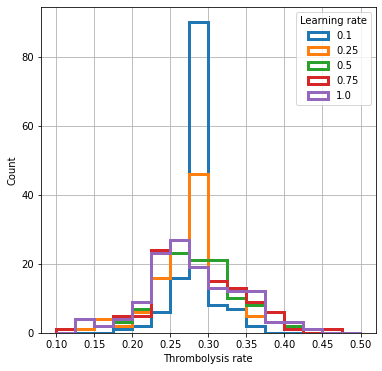

In [5]:
# Set up chart
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
for k, v in thrombolysis_rates_by_lr.items():
    ax.hist(v, 
            bins=np.arange(0.1, 0.51, 0.025),
            histtype='step',
            linewidth=3,
            label=k)
ax.legend(title='Learning rate')
ax.set_xlabel('Thrombolysis rate')
ax.set_ylabel('Count')
ax.grid()
plt.show()

In [17]:
results = dict()
for k, v in thrombolysis_rates_by_lr.items():
    mean = np.mean(v)
    stdev = np.std(v)
    minimum = np.min(v)
    maximum = np.max(v)
    results[k] = [mean, stdev, minimum, maximum]
    
results = pd.DataFrame(results, 
                       index=['Mean', 'StdDev', 'Min', 'Max'])

results

,0.10,0.25,0.50,0.75,1.00
Mean,0.281229,0.278714,0.279308,0.278464,0.278885
StdDev,0.023566,0.047150,0.058942,0.061381,0.059462
Min,0.197200,0.139300,0.110900,0.109000,0.133500
Max,0.360300,0.401300,0.421000,0.451600,0.430700
